### LIBRARY IMPORTING


In [1]:
#GENERAL
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#PATH PROCESS
import os
from pathlib import Path
#IMAGE PROCESS
import cv2
#MACHINE LEARNING
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Reshape, Dense,Flatten, GaussianNoise
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

## 1. RGB HISTOGRAM

Let's try RGB histogram approach, to see whether there are some similarities in terms of RGB values between galaxies

Let's load necessary data

In [2]:
train_paths=pd.read_pickle('../data/train_path_series.pkl')
test_paths=pd.read_pickle('../data/test_path_series.pkl')

We will apply a function, which generates histogram. It is based on our image path

In [3]:
def plot_rgb_histograms(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(12, 4))
    plt.title(f'RGB Histogram for {os.path.basename(image_path)}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.show()

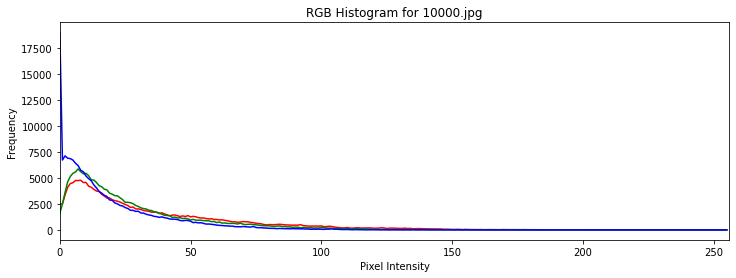

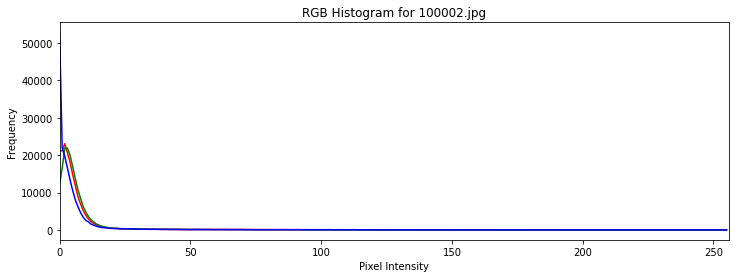

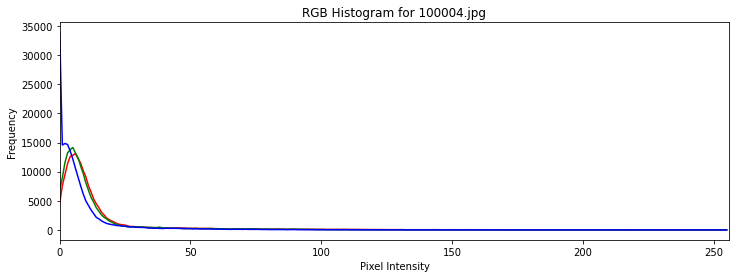

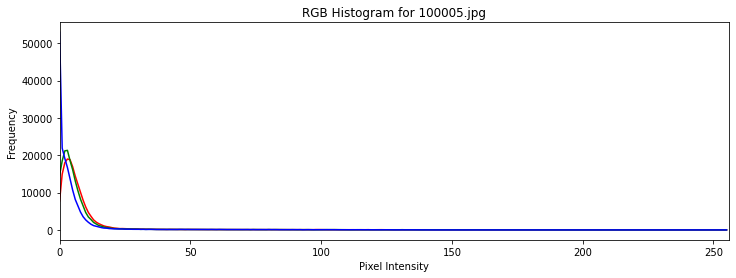

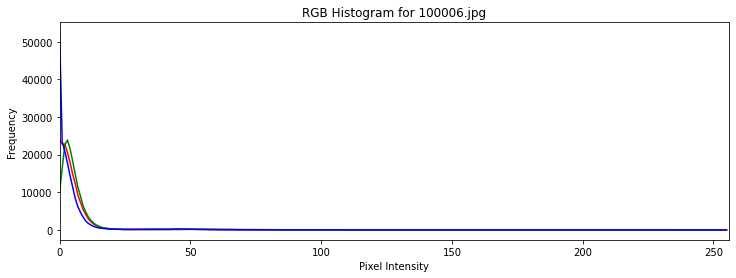

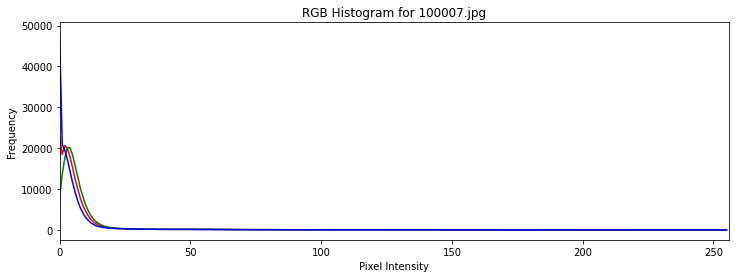

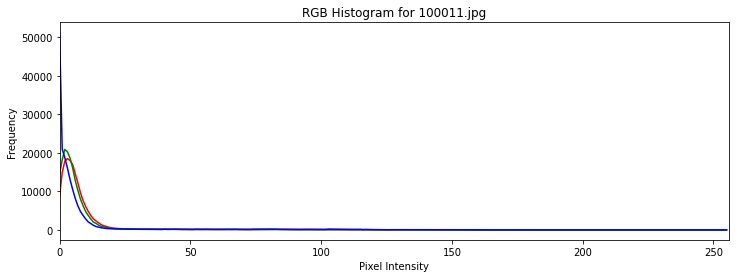

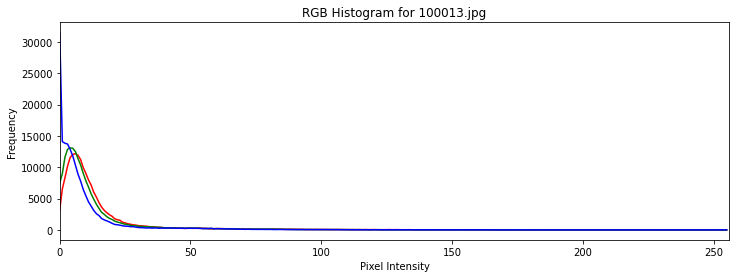

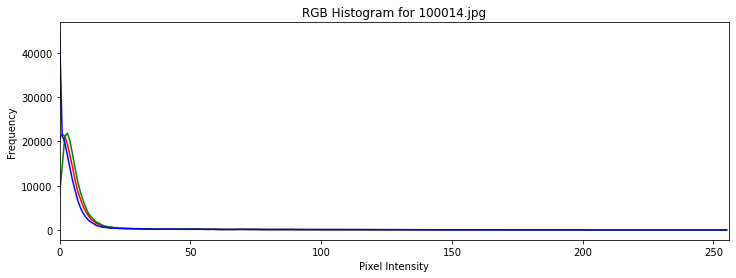

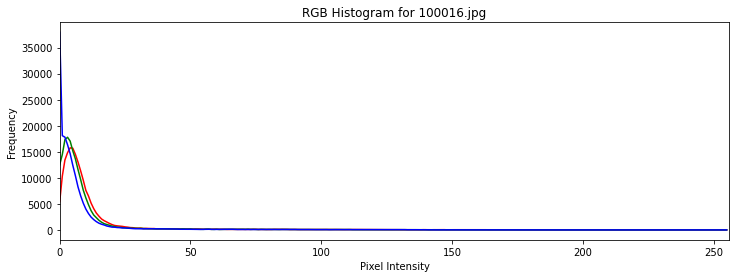

In [4]:
for train_path in train_paths.loc[1:10]:
    plot_rgb_histograms(train_path)

As we can see all of them look pretty similar. That's propably because of its' black background. 

Now we will build histograms for 1000 of our training galaxies, to see whether it will be interesting to test the model on the whole set

In [5]:
from sklearn.manifold import MDS


def calculate_rgb_histogram(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Image at path {image_path} could not be loaded.")
        return None
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        hist = hist.flatten()
        hist_features.extend(hist)
    return hist_features

# Calculate histograms for all images
histograms = [calculate_rgb_histogram(image_path) for image_path in train_paths.loc[1:1000,]]

Let's conduct normalization and KMeans clustering. We will focus on 3 clusters and use MDS method

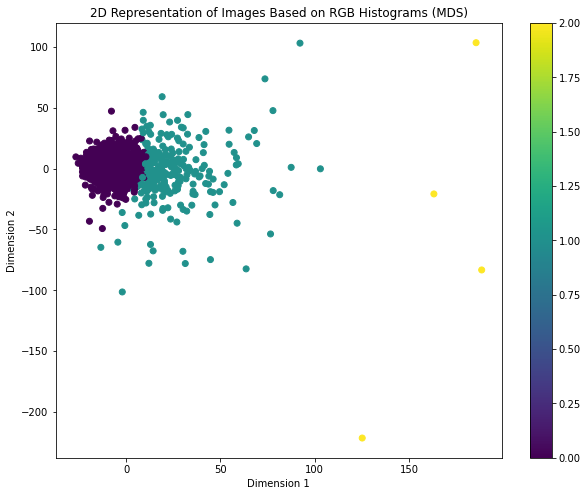

In [6]:
# Normalize the histograms
scaler = StandardScaler()
histograms_normalized = scaler.fit_transform(histograms)

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(histograms_normalized)

# Perform MDS to reduce dimensions to 2D
mds = MDS(n_components=2, random_state=42)
histograms_2d_mds = mds.fit_transform(histograms_normalized)

# Plot the 2D representation of the images
plt.figure(figsize=(10, 8))
plt.scatter(histograms_2d_mds[:, 0], histograms_2d_mds[:, 1], c=clusters, cmap='viridis', marker='o')
#for i, image_path in enumerate(train_paths.loc[1:10000,]):
    #plt.text(histograms_2d_mds[i, 0], histograms_2d_mds[i, 1], os.path.basename(image_path), fontsize=9)
plt.title('2D Representation of Images Based on RGB Histograms (MDS)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

Let's take 3 examples from different clusters to see some similarities or differences between them

In [7]:
image_paths=["..\\images_gz2\\images\\100774.jpg","..\\images_gz2\\images\\100108.jpg","..\\images_gz2\\images\\101801.jpg"]

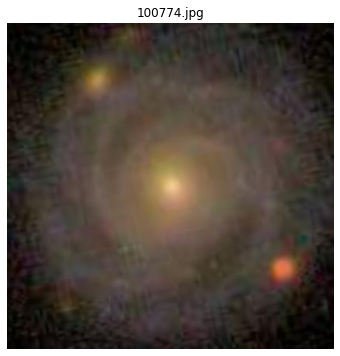

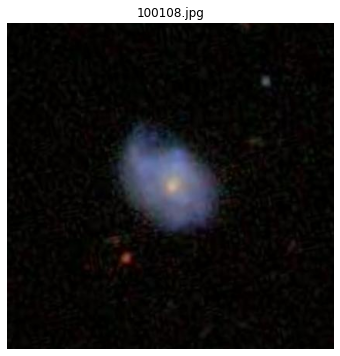

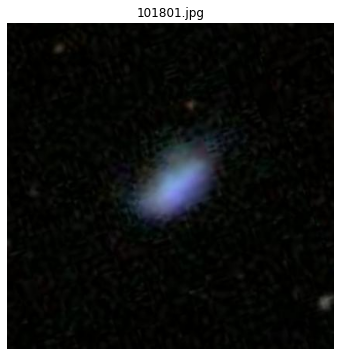

In [8]:
for image_path in image_paths:
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(os.path.basename(image_path))
        plt.axis('off')
        plt.show()

Let's see how yellow cluster images look like

In [9]:
image_paths_2=["..\\images_gz2\\images\\100774.jpg","..\\images_gz2\\images\\101022.jpg","..\\images_gz2\\images\\100113.jpg","..\\images_gz2\\images\\100966.jpg"]

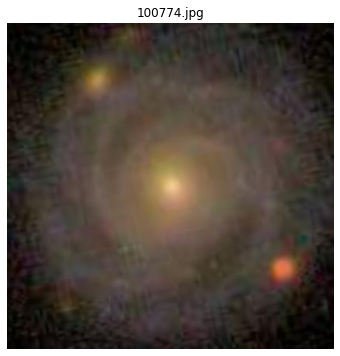

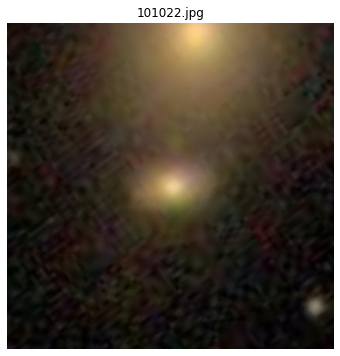

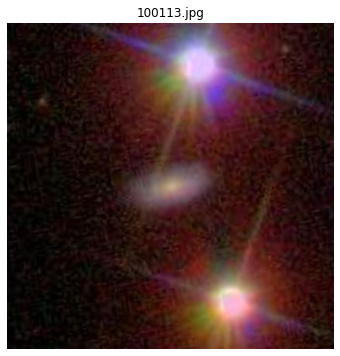

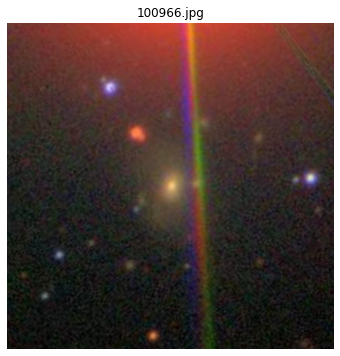

In [10]:
for image_path in image_paths_2:
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(os.path.basename(image_path))
        plt.axis('off')
        plt.show()

We can clearly see that galaxies in the yellow clusters have a lot of differences between them and other galaxies. Unfortunately our division is not equal - we have only 4 galaxies in yellow cluster and much more in others. Further exploring is rather meaningless

## 2. BAG OF VISUAL WORDS

### 2.1 KMeans

Firstly, we will focus on feature extraction

In [11]:
sift = cv2.SIFT_create()
descriptors_list = []
correct_paths=[]

In [12]:
train_paths_2=train_paths.loc[1:1000]

for image_path in train_paths_2:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None and len(descriptors) > 0:
            descriptors_list.append(descriptors)
            correct_paths.append(image_path)
        else:
            print(f"Warning: No descriptors found for image at path {image_path}")
    else:
        print(f"Warning: Image at path {image_path} could not be loaded.")


Vocabulary creation

In [13]:
descriptors_list = np.vstack(descriptors_list)

In [14]:
# Debugging: Check the shape of the descriptors list
print("Shape of descriptors list:", descriptors_list.shape)

# Step 2: Vocabulary Creation
k = 50  # Number of visual words
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(descriptors_list)
vocabulary = kmeans.cluster_centers_

# Debugging: Check if the vocabulary is created correctly
print("Shape of vocabulary:", vocabulary.shape)

Shape of descriptors list: (28887, 128)
Shape of vocabulary: (50, 128)


Computing histograms with visual words

In [15]:
def compute_histogram(image_path, kmeans, k):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None and len(descriptors) > 0:
            print(f"Descriptors shape for {image_path}: {descriptors.shape}")
            visual_words = kmeans.predict(descriptors)
            histogram, _ = np.histogram(visual_words, bins=np.arange(0, k + 1))
            return histogram
        else:
            print(f"Warning: No descriptors found for image at path {image_path}")
    else:
        print(f"Warning: Image at path {image_path} could not be loaded.")
    return np.zeros(k)

In [16]:
histograms = np.array([compute_histogram(image_path, kmeans, k) for image_path in correct_paths])

Descriptors shape for ..\images_gz2\images\10000.jpg: (53, 128)
Descriptors shape for ..\images_gz2\images\100002.jpg: (21, 128)
Descriptors shape for ..\images_gz2\images\100004.jpg: (18, 128)
Descriptors shape for ..\images_gz2\images\100005.jpg: (8, 128)
Descriptors shape for ..\images_gz2\images\100006.jpg: (11, 128)
Descriptors shape for ..\images_gz2\images\100007.jpg: (71, 128)
Descriptors shape for ..\images_gz2\images\100011.jpg: (4, 128)
Descriptors shape for ..\images_gz2\images\100013.jpg: (28, 128)
Descriptors shape for ..\images_gz2\images\100014.jpg: (12, 128)
Descriptors shape for ..\images_gz2\images\100016.jpg: (25, 128)
Descriptors shape for ..\images_gz2\images\100017.jpg: (15, 128)
Descriptors shape for ..\images_gz2\images\100018.jpg: (61, 128)
Descriptors shape for ..\images_gz2\images\10002.jpg: (41, 128)
Descriptors shape for ..\images_gz2\images\100021.jpg: (36, 128)
Descriptors shape for ..\images_gz2\images\100022.jpg: (60, 128)
Descriptors shape for ..\imag

The final shape of our data looks like this:

In [17]:
print("Shape of histograms:", histograms.shape)

Shape of histograms: (998, 50)


Let's normalize our data

In [21]:
scaler = StandardScaler()
histograms_normalized = scaler.fit_transform(histograms)

We will check how many clusters are we going to choose

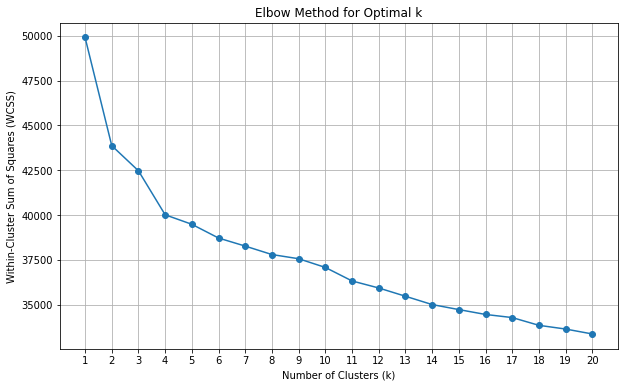

In [22]:
wcss = []
k_values = range(1, 21)  # We'll test for 1 to 20 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(histograms_normalized)
    wcss.append(kmeans.inertia_)

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

We have chosen to build our model on 4 clusters

In [24]:
num_clusters = 4
kmeans_cluster = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans_cluster.fit_predict(histograms_normalized)

We will again use MDS to reduce number of dimensions to 2.

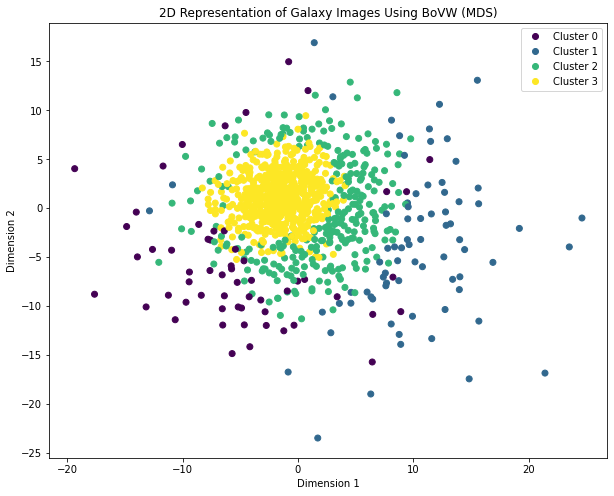

In [25]:
mds = MDS(n_components=2, random_state=42)
histograms_2d_mds = mds.fit_transform(histograms_normalized)

# Plot the 2D representation of the images
plt.figure(figsize=(10, 8))
scatter = plt.scatter(histograms_2d_mds[:, 0], histograms_2d_mds[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('2D Representation of Galaxy Images Using BoVW (MDS)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(num_clusters)])
plt.show()

Nothing interesting again. Maybe other clustering method will work much better.

### 2.2 Agglomerative Clustering

Now we will use different clustering -> Agglomerative clustering
Compiling the code below takes too much time. If you want to save the time move to another point, where we load the data, which we have already saved.

In [26]:
sift = cv2.SIFT_create()
descriptors_list = []

for image_path in train_paths_2:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None and len(descriptors) > 0:
            descriptors_list.append(descriptors)
        else:
            print(f"Warning: No descriptors found for image at path {image_path}")
    else:
        print(f"Warning: Image at path {image_path} could not be loaded.")

# Check if descriptors list contains elements
if len(descriptors_list) == 0:
    raise ValueError("No descriptors found. Ensure images are loaded correctly and contain detectable features.")

# Flatten the list of descriptors into a 2D array
descriptors_list = np.vstack(descriptors_list)

# Debugging: Check the shape of the descriptors list
print("Shape of descriptors list:", descriptors_list.shape)


KeyboardInterrupt: 

In [ ]:
# Step 2: Vocabulary Creation
k = 50  # Number of visual words
# Using Agglomerative Clustering to create the vocabulary
agglo_cluster = AgglomerativeClustering(n_clusters=k)
visual_words = agglo_cluster.fit_predict(descriptors_list)
vocabulary = np.zeros((k, descriptors_list.shape[1]))
for i in range(k):
    indices = np.where(visual_words == i)[0]
    if len(indices) > 0:
        vocabulary[i] = np.mean(descriptors_list[indices], axis=0)

# Debugging: Check if the vocabulary is created correctly
print("Shape of vocabulary:", vocabulary.shape)

Let's save both of the arrays

In [ ]:
np.save('visual_words_agglo_cluster.npy',visual_words)
np.save('vocabulary_agglo_cluster.npy',vocabulary)

NameError: name 'visual_words' is not defined

Loading of visual_words and vocabulary

In [27]:
visual_words=np.load('visual_words_agglo_cluster.npy')
vocabulary=np.load('vocabulary_agglo_cluster.npy')
k=50

In [28]:
def compute_histogram(image_path, vocabulary, k):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None and len(descriptors) > 0:
            # Compute the histogram of visual words
            visual_words = np.argmin(np.linalg.norm(descriptors[:, np.newaxis] - vocabulary, axis=2), axis=1)
            histogram, _ = np.histogram(visual_words, bins=np.arange(0, k + 1))
            return histogram
        else:
            print(f"Warning: No descriptors found for image at path {image_path}")
    else:
        print(f"Warning: Image at path {image_path} could not be loaded.")
    return np.zeros(k)

# Generate histograms for all images
histograms = np.array([compute_histogram(image_path, vocabulary, k) for image_path in correct_paths])

# Debugging: Check the shape of the histograms
print("Shape of histograms:", histograms.shape)

Shape of histograms: (998, 50)


Let's normalize the data and finally use our Agglomerative Cluster approach. We will use 3 clusters instead of 4.

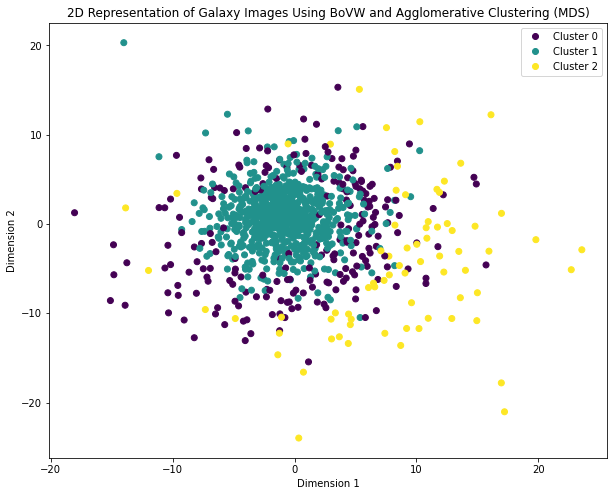

In [29]:
# Step 4: Clustering
scaler = StandardScaler()
histograms_normalized = scaler.fit_transform(histograms)

# Using Agglomerative Clustering for final clustering
num_clusters = 3
agglo_cluster_final = AgglomerativeClustering(n_clusters=num_clusters)
clusters = agglo_cluster_final.fit_predict(histograms_normalized)

# Reduce dimensions for visualization using MDS
mds = MDS(n_components=2, random_state=42)
histograms_2d_mds = mds.fit_transform(histograms_normalized)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(histograms_2d_mds[:, 0], histograms_2d_mds[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('2D Representation of Galaxy Images Using BoVW and Agglomerative Clustering (MDS)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(num_clusters)])
plt.show()

Again nothing ineresting unfortunatelly

We will try to check another method. We are going to focus on clustering by using ResNet50 model

# 3. ResNet50 Model

In [30]:
# Step 1: Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [35]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

In [38]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [39]:
features_list = []
for image_path in train_paths_2:
    img_data = load_and_preprocess_image(image_path)
    features = model.predict(img_data)
    features_list.append(features.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━

In [40]:
# Convert the list of features into a numpy array
features_array = np.array(features_list)

Let's normalize features and conduct again Agglomerative Clustering

In [41]:
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_array)

In [42]:
# Step 4: Perform Agglomerative Clustering
num_clusters = 3
agglo_cluster = AgglomerativeClustering(n_clusters=num_clusters)
clusters = agglo_cluster.fit_predict(features_normalized)

We will now use t-sne to reduce dimensions

In [43]:
tsne = TSNE(n_components=3, random_state=42)
features_3d_tsne = tsne.fit_transform(features_normalized)

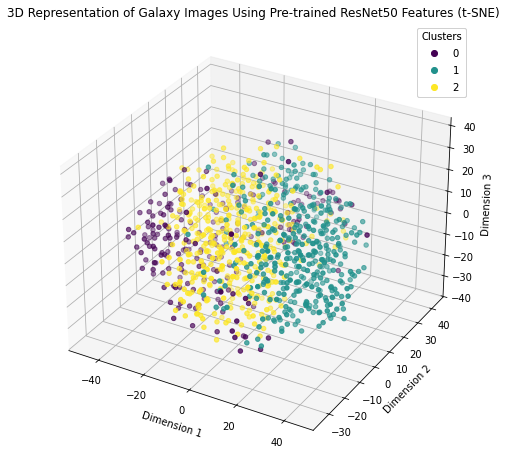

In [44]:
# Plot the 3D representation of the images
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_3d_tsne[:, 0], features_3d_tsne[:, 1], features_3d_tsne[:, 2], c=clusters, cmap='viridis', marker='o')
ax.set_title('3D Representation of Galaxy Images Using Pre-trained ResNet50 Features (t-SNE)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()

Again huge cloud of points - nothing interesting

Now let's visualize it in 2D version, we will use again MDS method to reduce dimensions

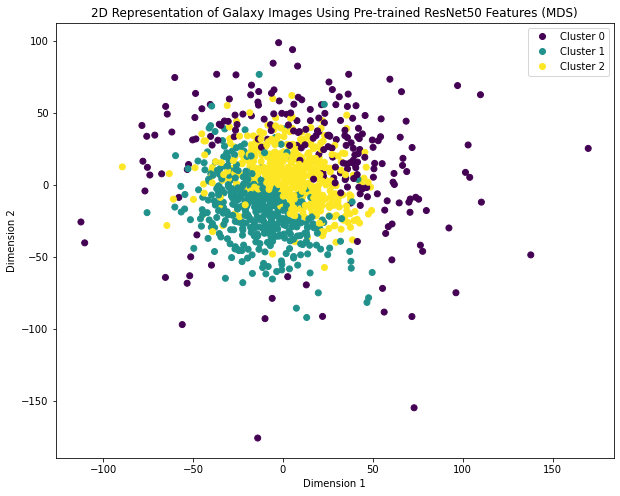

In [45]:
mds = MDS(n_components=2, random_state=42)
features_2d_mds = mds.fit_transform(features_normalized)

# Plot the 2D representation of the images
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d_mds[:, 0], features_2d_mds[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('2D Representation of Galaxy Images Using Pre-trained ResNet50 Features (MDS)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(num_clusters)])
plt.show()

Again we can observe similar output

# 4. TRANSOFRMATED IMG SCALED DATA

Now we will change our considered dataset from the original to transformated one, which was built in EDA stage, Let's firstly load the data

In [46]:
Transformated_IMG_Scaled_Train=np.load("Transformated_IMG_Scaled_Train.npy")
Transformated_IMG_Scaled_Test=np.load("Transformated_IMG_Scaled_Test.npy")


In [49]:
train_images = Transformated_IMG_Scaled_Train.reshape((Transformated_IMG_Scaled_Train.shape[0], -1))
test_images = Transformated_IMG_Scaled_Test.reshape((Transformated_IMG_Scaled_Test.shape[0], -1))

In [47]:
# Function to visualize clusters
def plot_clusters(data, labels, title):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar()
    plt.show()

We will calculate and see which number of clusters is the best for our situation

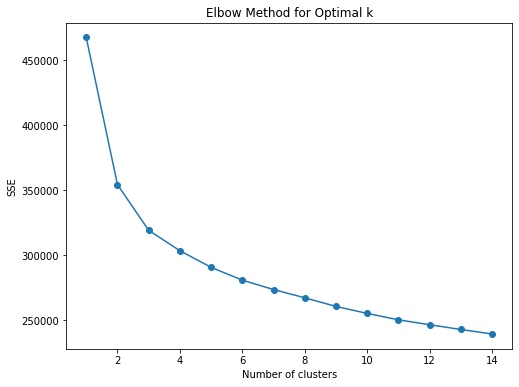

In [25]:
# Function to calculate and plot the Elbow method for KMeans
def plot_elbow_method(data):
    sse = []
    for k in range(1, 15):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 15), sse, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

# Plot Elbow Method for KMeans
plot_elbow_method(train_images)

We are going to choose 3 clusters and check which of the following clustering methods fits the best to our situation

In [51]:
# Clustering models
clustering_models = {
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=3),
    'Agglomerative Ward': AgglomerativeClustering(n_clusters=3, linkage='ward'),
    'Agglomerative Complete': AgglomerativeClustering(n_clusters=3, linkage='complete'),
    'Agglomerative Average': AgglomerativeClustering(n_clusters=3, linkage='average'),
    'Agglomerative Single': AgglomerativeClustering(n_clusters=3, linkage='single'),
    'GaussianMixture': GaussianMixture(n_components=3, random_state=42)
}

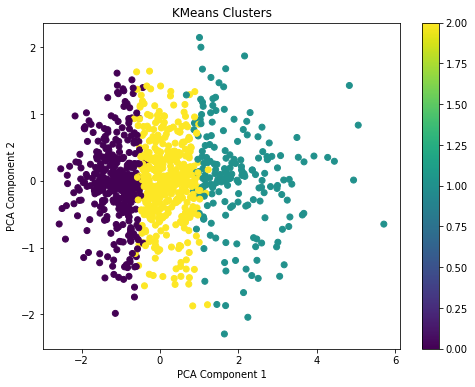

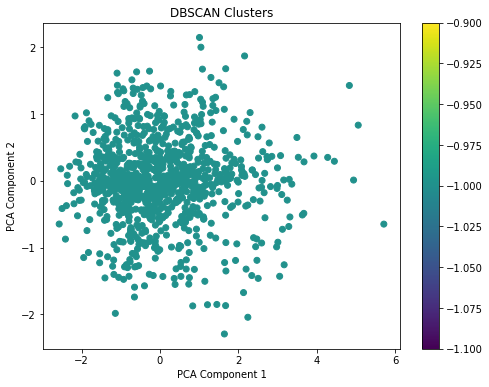

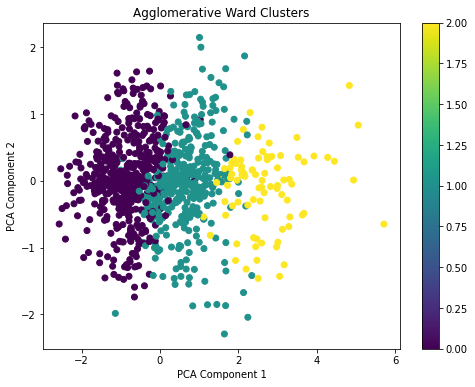

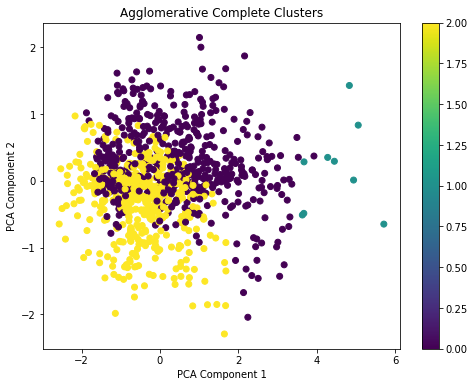

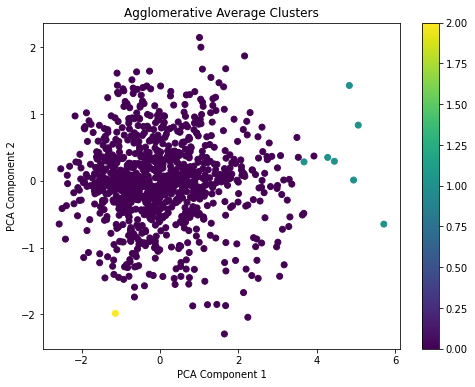

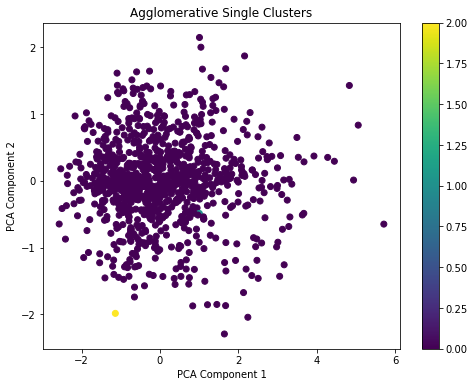

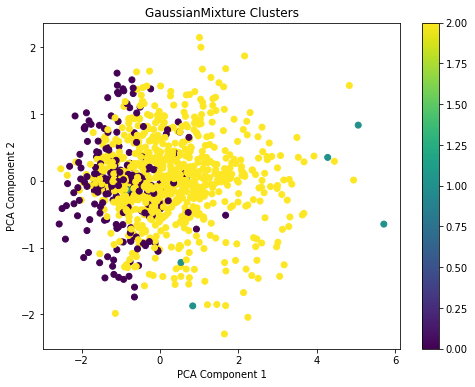

In [52]:
results = []

for model_name, model in clustering_models.items():
    # Fit the model on train images
    if model_name in ['DBSCAN', 'Agglomerative Single', 'Agglomerative Complete', 'Agglomerative Average', 'Agglomerative Ward']:
        model.fit(train_images[1:1000])
        labels = model.fit_predict(test_images[1:1000])
    else:
        model.fit(train_images[1:1000])
        labels = model.predict(test_images[1:1000])
    
    # Visualize clusters
    plot_clusters(test_images[1:1000], labels, title=f'{model_name} Clusters')
    
    # Store results
    results.append({
        'Model': model_name,
        'Labels': labels
    })

Three of the considered methods generate only one cluster (or the clusters have very low count). Other methods are also not interesting. We can clearly see that neither of the clusters actually outstands from the rest of them. 

# 5. AUTO ENCODER DATA

Let's load the data:

In [53]:
After_Auto_Encoder_Train= np.load('After_Auto_Encoder_Train.npy')
After_Auto_Encoder_Test= np.load('After_Auto_Encoder_Test.npy')

In [54]:
train_images_2 = After_Auto_Encoder_Train.reshape((After_Auto_Encoder_Train.shape[0], -1))
test_images_2 = After_Auto_Encoder_Test.reshape((After_Auto_Encoder_Test.shape[0], -1))

We will check what elbow method shows us and how many clusters does it propose to us.

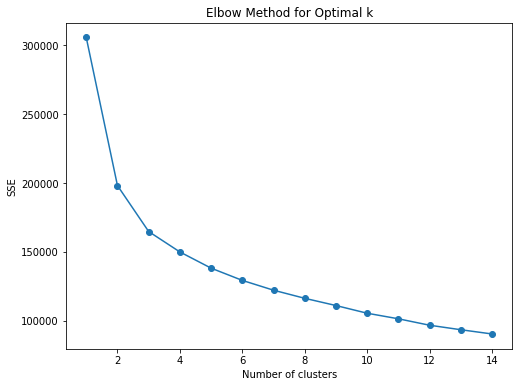

In [55]:
# Function to calculate and plot the Elbow method for KMeans
def plot_elbow_method(data):
    sse = []
    for k in range(1, 15):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 15), sse, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

# Plot Elbow Method for KMeans
plot_elbow_method(train_images_2)

We will again choose three as a number of clusters. To reduce dimensions we will use PCA method.

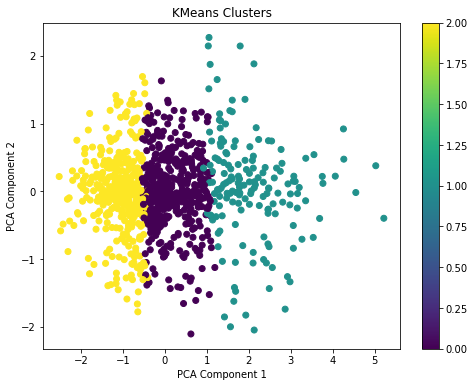

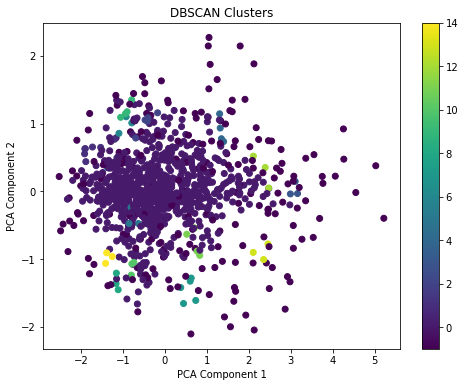

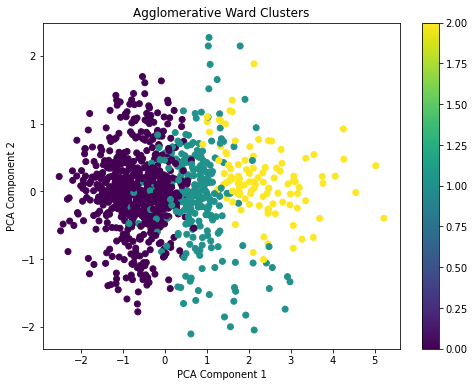

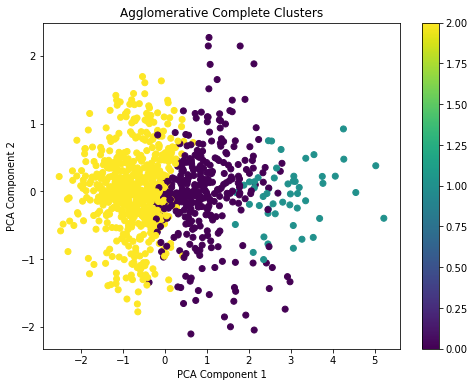

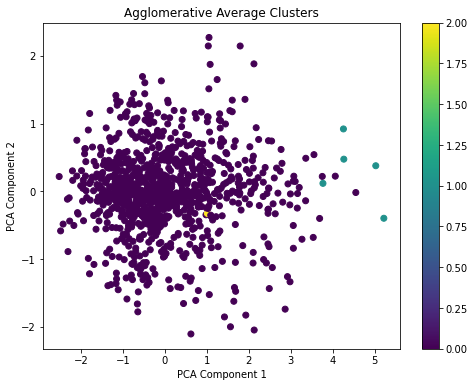

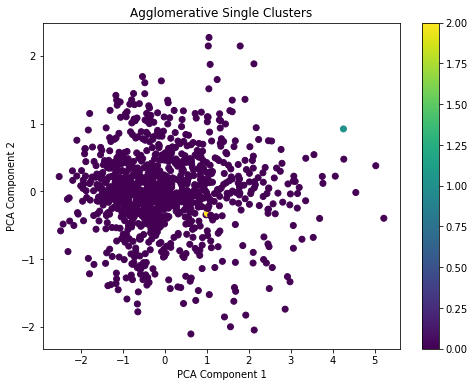

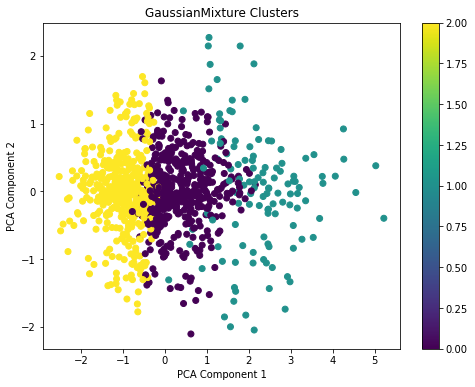

In [56]:
results = []

for model_name, model in clustering_models.items():
    # Fit the model on train images
    if model_name in ['DBSCAN', 'Agglomerative Single', 'Agglomerative Complete', 'Agglomerative Average', 'Agglomerative Ward']:
        model.fit(train_images_2[1:10000])
        labels = model.fit_predict(test_images_2[1:1000])
    else:
        model.fit(train_images_2[1:10000])
        labels = model.predict(test_images_2[1:1000])
    
    # Visualize clusters
    plot_clusters(test_images_2[1:1000], labels, title=f'{model_name} Clusters')

    if len(np.unique(labels)) > 1:
        silhouette_avg = silhouette_score(test_images_2[1:1000], labels)
    else:
        silhouette_avg = -1  # Undefined for a single cluster
    
    # Store results
    results.append({
        'Model': model_name,
        'Labels': labels,
        'Silhouette Score': silhouette_avg
    })

We can see that auto encoding doesn't divide our data into interesting parts. Of course clustering methods try to find interesting connections, but it does not satisfy us. Let's check also Silhouette score

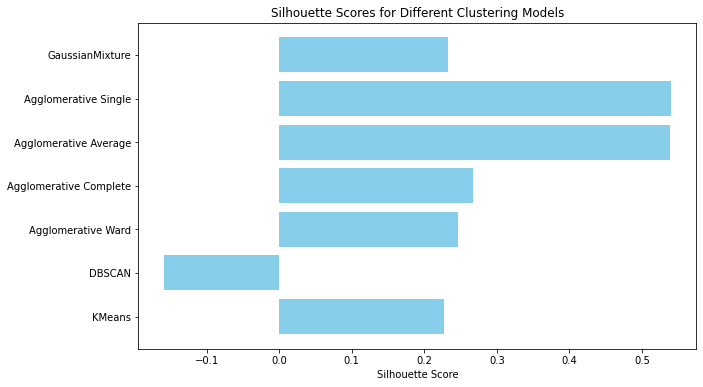

In [44]:
silhouette_scores = [result['Silhouette Score'] for result in results]
model_names = [result['Model'] for result in results]

plt.figure(figsize=(10, 6))
plt.barh(model_names, silhouette_scores, color='skyblue')
plt.xlabel('Silhouette Score')
plt.title('Silhouette Scores for Different Clustering Models')
plt.show()

Agglomerative Single and Agglomerative Average have decent results, but when we come back to the plots we can see that both of the methods have mostly one cluster and in this situation Silhouette metrics won't be great solution.

# 6. DRAWING CONTOURS

We will draw contours and check whether images will be more similar to each other and more distirbuted in 2D space

In [57]:
# Function to draw contours around the galaxy in an image
def draw_contours(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to get a binary image
    _, binary = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on the original image
    contour_image = image.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    
    # Convert BGR to RGB for displaying with matplotlib
    contour_image = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)
    
    return contour_image

Let's plot ten example images

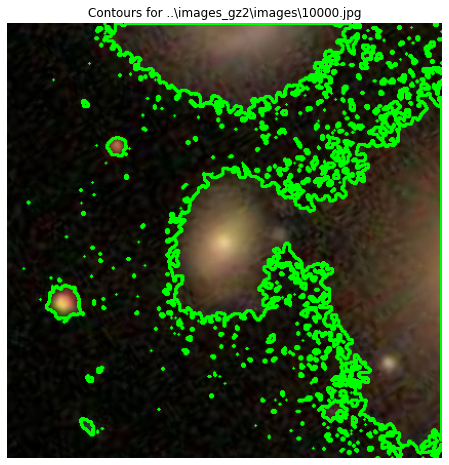

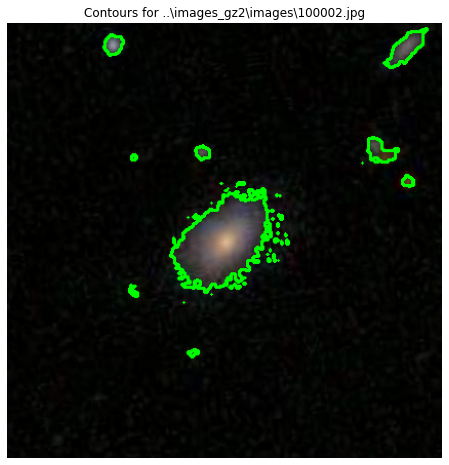

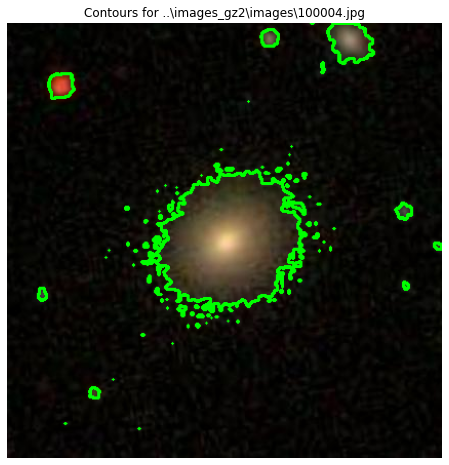

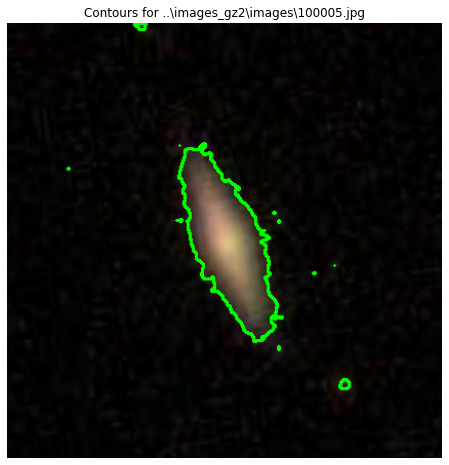

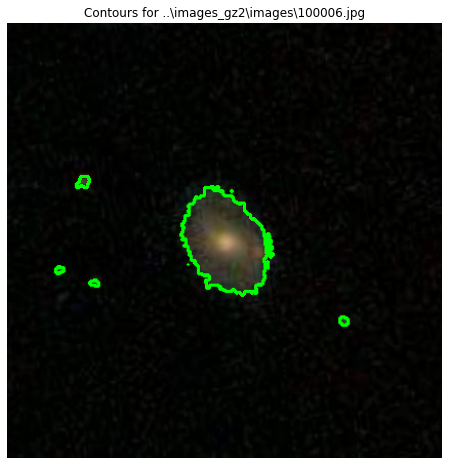

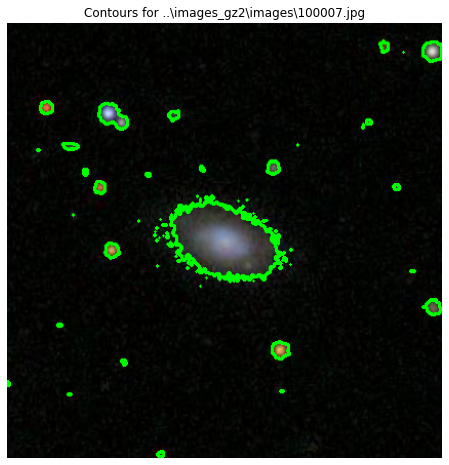

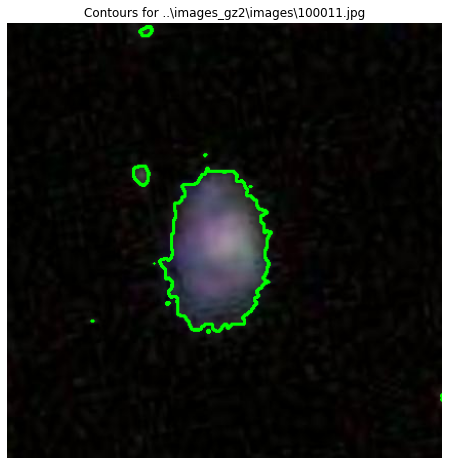

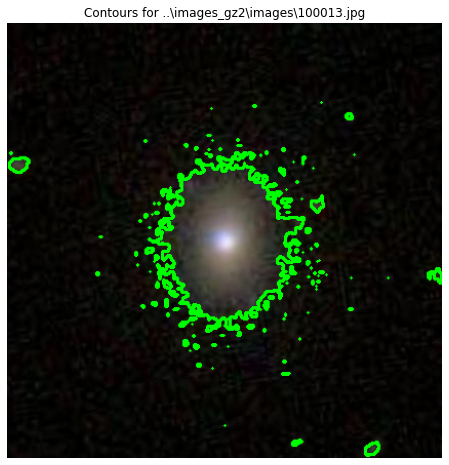

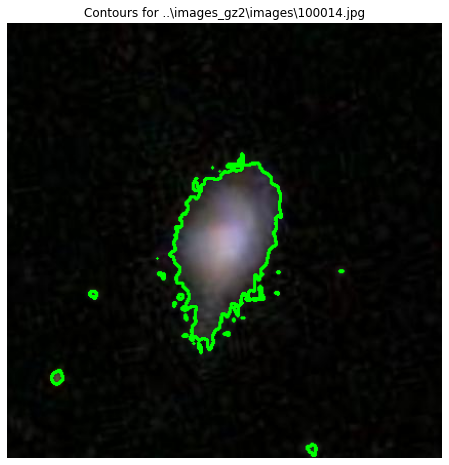

In [58]:
for image_path in train_paths[1:10]:
    contour_image = draw_contours(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(contour_image)
    plt.title(f'Contours for {image_path}')
    plt.axis('off')
    plt.show()


In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import os

We will use HuMoments method to calculate largest contour and compare the galaxies

In [60]:
def extract_hu_moments(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to get a binary image
    _, binary = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate Hu Moments for the largest contour
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        hu_moments = cv2.HuMoments(cv2.moments(largest_contour)).flatten()
    else:
        hu_moments = np.zeros(7)  # If no contour is found, return a zero vector
    
    return hu_moments

In [61]:
features_list = []
for image_path in train_paths[1:1000]:
    hu_moments = extract_hu_moments(image_path)
    features_list.append(hu_moments)

features_array = np.array(features_list)

Normalize the data

In [63]:
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_array)

We will check, which components are the most necesarry and reject the least ineteresting ones

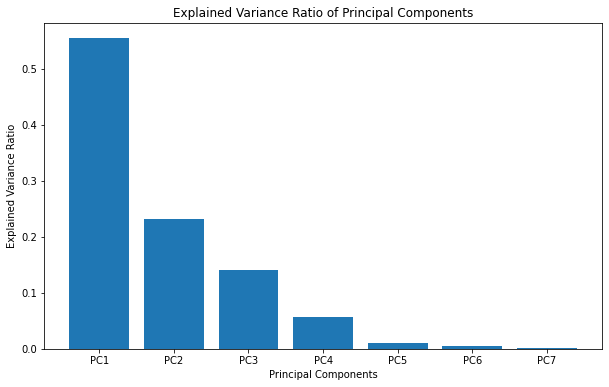

In [65]:
pca = PCA(n_components=7)  # 7 because we have 7 Hu Moments
pca_features = pca.fit_transform(features_normalized)

# Plot explained variance ratio to visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 8), pca.explained_variance_ratio_, tick_label=[f'PC{i}' for i in range(1, 8)])
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

We select 3 as a number of clusters and use no of components in t-sne as two

In [67]:
# Step 4: Perform Agglomerative Clustering
num_clusters = 3
agglo_cluster = AgglomerativeClustering(n_clusters=num_clusters)
clusters = agglo_cluster.fit_predict(features_normalized)

# Step 5: Reduce dimensions for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d_tsne = tsne.fit_transform(features_normalized)

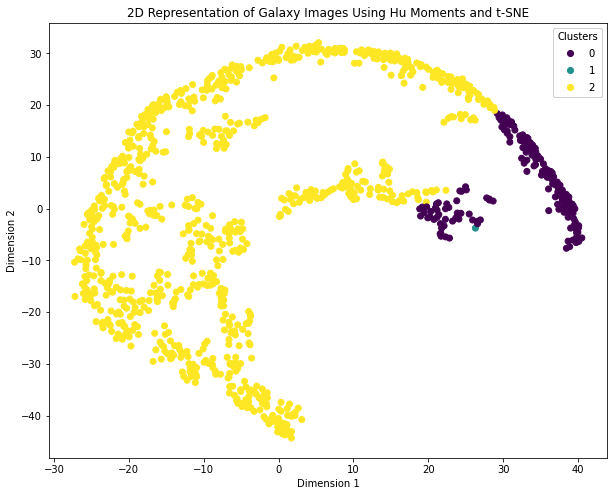

In [68]:
# Plot the 3D representation of the images
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('2D Representation of Galaxy Images Using Hu Moments and t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)
plt.show()

We can see that this looks much better than the previous data, but still we face difficulties to see exactly 3 clusters

We will try now to check other clustering methods

In [69]:
clustering_methods = {
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=2),
    'GMM': GaussianMixture(n_components=3, random_state=42)
}

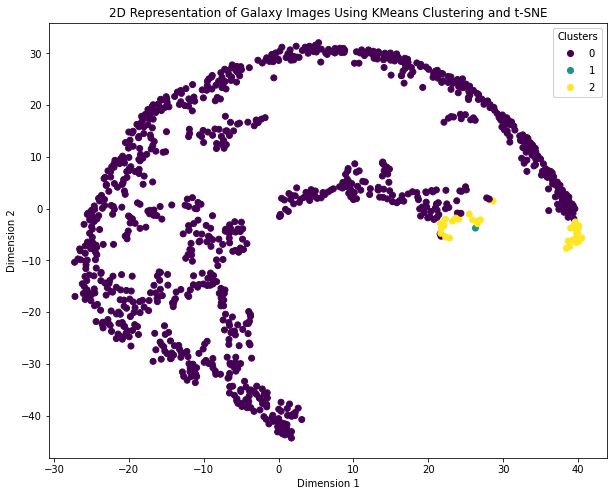

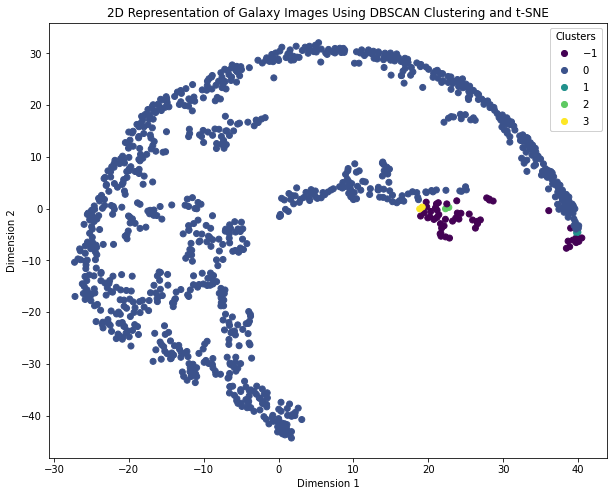

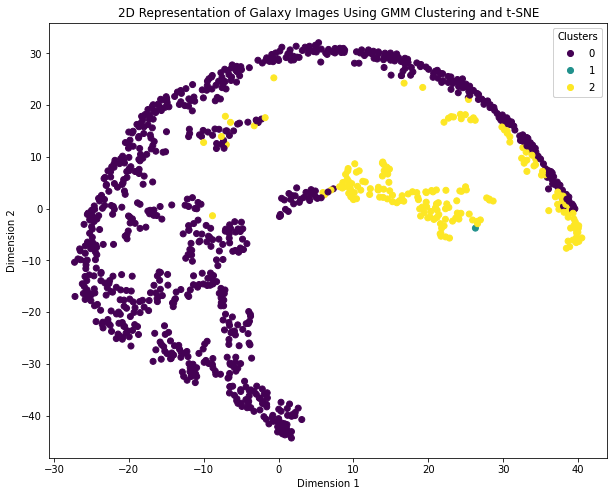

In [70]:
for method_name, method in clustering_methods.items():
    # Fit the clustering method
    clusters = method.fit_predict(pca_features)
    
    # Step 6: Reduce dimensions for visualization using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d_tsne = tsne.fit_transform(pca_features)
    
    # Plot the 2D representation of the images with feature importance
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.title(f'2D Representation of Galaxy Images Using {method_name} Clustering and t-SNE')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    plt.show()

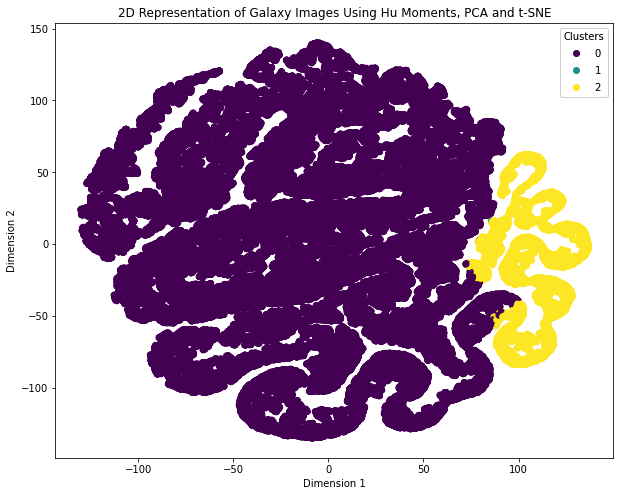

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Funkcja do ekstrakcji Hu Moments z konturów obrazu
def extract_hu_moments(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        hu_moments = cv2.HuMoments(cv2.moments(largest_contour)).flatten()
    else:
        hu_moments = np.zeros(7)
    return hu_moments

# Lista ścieżek do obrazów

# Ekstrakcja Hu Moments dla każdego obrazu
features_list = [extract_hu_moments(image_path) for image_path in train_paths]
features_array = np.array(features_list)

# Normalizacja cech
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_array)

# Redukcja wymiarowości za pomocą PCA
pca = PCA(n_components=7)
pca_features = pca.fit_transform(features_normalized)

# Klasteryzacja za pomocą KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_features)

# Redukcja wymiarowości za pomocą t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d_tsne = tsne.fit_transform(pca_features)

# Wizualizacja klastrów
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('2D Representation of Galaxy Images Using Hu Moments, PCA and t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)
plt.show()